# Benchmark scripts

In [1]:
# Load required modules
%matplotlib inline

from IPython.display import display

import numpy as np
import os, sys, time
from importlib import reload

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import KP07
from gpuocean.utils import IPythonMagic, PlotHelper, DrifterPlotHelper
from gpuocean.utils import Common, BathymetryAndICs


In [2]:
# Create the GPU context
%cuda_context_handler gpu_ctx

In [3]:
def test_args_in(a=10, b=20, c=30):
    print(f"Values received: a={a}, b={b}, c={c}")

def conceptual_runKP07(nx, ny, dt, T, **kwargs):
    test_args_in(**kwargs)

conceptual_runKP07(10, 10, 0.1, 10, b=60, c=55)

Values received: a=10, b=60, c=55


In [72]:
def initKP07(nx, ny, dt, depth=2, init="bump", oneD=False, domain_size=1000, **kwargs):
    # define square domain
    # domain_size = 1000
    dx = domain_size/nx
    dy = domain_size/ny
    
    assert (dt > 0), "For benchmarking, we require dt > 0 so that number of timesteps is known"

    eta0, hu0, hv0 = (np.zeros((ny+4, nx+4), dtype=np.float32) for _ in range(3))
    Hi = np.ones((ny+5, nx+5), dtype=np.float32)*depth

    valid_init = ["bump", "shock"]
    assert(init in valid_init), 'init='+init+' is not a valid value. Please use any of '+valid_init
    if init == valid_init[0]:
        for j in range(ny+4):
            y = (j-2+0.5)*dy
            if oneD:
                y = domain_size/2
            for i in range(nx+4):
                x = (i-2+0.5)*dx
                eta0[j,i] = np.exp(-((x-domain_size/2)**2 + (y-domain_size/2)**2)/50**2)

    if init == valid_init[1]:
        eta0[0:nx//2, :] +=1
        #eta0[:, 0:ny//2] +=1

    return KP07.KP07(gpu_ctx, eta0, Hi, hu0, hv0, nx, ny, dx, dy, dt, 9.81, theta=2.0)

reload(KP07)
dt = 0.002
nx = 2048*16
ny = 1
if 'sim_shock' in globals():
    sim_shock.cleanUp()
if 'sim_bump' in globals():
    sim_bump.cleanUp()
if 'sim_dry' in globals():
    sim_dry.cleanUp()
    
sim_shock = initKP07(nx, ny, dt,  init='shock')
sim_bump = initKP07(nx, ny, dt,  init='bump', oneD=True)
sim_dry = initKP07(nx, ny, dt,  init='shock', depth=0)

In [73]:
def run_benchmark(sim, numTimesteps):
    def subrun(sim, T):
        for i in range(T):
            sim.step(sim.dt)

    tic = time.time()
    
    # Warm up
    subrun(sim, 10)
    _ = sim.download()
    warm_up_t = time.time() - tic
    
    # benchmark
    subrun(sim, numTimesteps)
    sim.gpu_stream.synchronize()
    benchmark_run_t = time.time() - tic
    _ = sim.download()
    benchmark_sync_t = time.time() - tic

    # cool down
    subrun(sim, 10)
    _ = sim.download()
    cool_down_t = time.time() - tic

    print("{:02.4f} s: ".format(warm_up_t) + "warm_up_t")
    print("{:02.4f} s: ".format(benchmark_run_t) + "benchmark_run_t")
    print("{:02.4f} s: ".format(benchmark_sync_t) + "benchmark_sync_t")
    print("{:02.4f} s: ".format(cool_down_t) + "cool_down_t")


In [74]:
T = 20000
#run_benchmark(sim_shock, T)
run_benchmark(sim_bump, T)
#run_benchmark(sim_dry, T)


0.0300 s: warm_up_t
26.9141 s: benchmark_run_t
26.9171 s: benchmark_sync_t
26.9361 s: cool_down_t


([<AxesSubplot:title={'center':'eta'}>,
  <AxesSubplot:title={'center':'hu'}>,
  <AxesSubplot:title={'center':'hv'}>],
  <matplotlib.image.AxesImage at 0x1e0841cb888>])

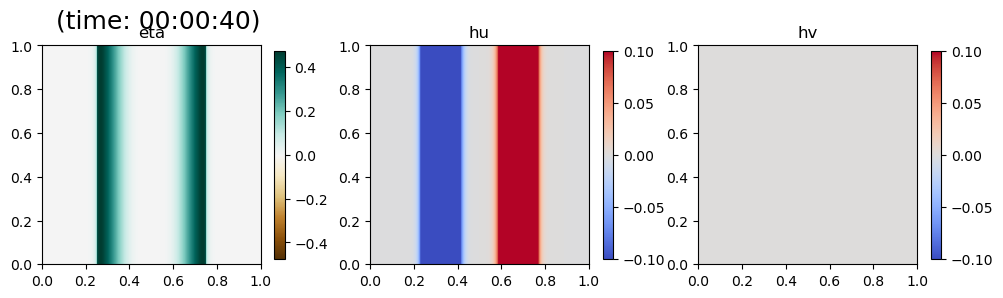

In [75]:
# PlotHelper.plotSim(sim_shock)
PlotHelper.plotSim(sim_bump)
# PlotHelper.plotSim(sim_dry)

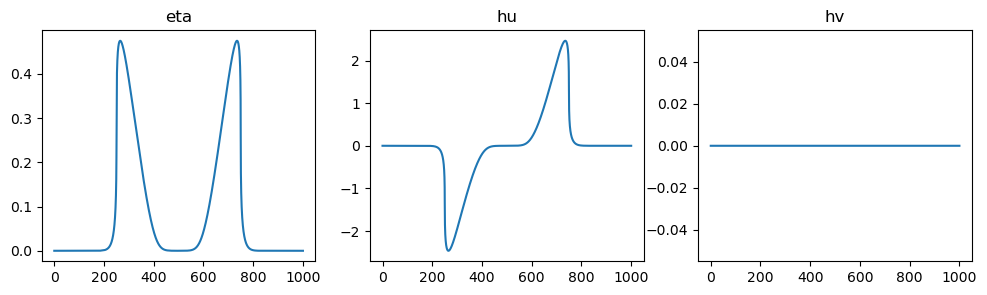

In [77]:
def plot1D(sim, x=None, y=None):
    eta, hu, hv = sim.download(interior_domain_only=True)
    xaxis = None
    if y is not None:
        eta, hu, hv = eta[y, :], hu[y,:], hv[y,:]
        xaxis = np.linspace(sim.dx/2, sim.dx*(sim.nx-0.5), sim.nx)
    else:
        if x is None:
            x = sim.nx//2
        eta, hu, hv = eta[:, x], hu[:,x], hv[:,x]
        xaxis = np.linspace(sim.dy/2, sim.dy*(sim.ny-0.5), sim.ny)

    fig = plt.figure(figsize=(12, 3))  
    
    data=[eta, hu, hv]
    titles = ['eta', 'hu', 'hv']
    
    for i in range(3):
        ax = plt.subplot(1,3,i+1)
        ax.plot(xaxis, data[i])
        ax.set_title(titles[i])

   #print(eta)

# plot1D(sim_shock, y=3)
plot1D(sim_bump, y =0)
# plot1D(sim_dry)

([<AxesSubplot:title={'center':'eta'}>,
  <AxesSubplot:title={'center':'hu'}>,
  <AxesSubplot:title={'center':'hv'}>],
  <matplotlib.image.AxesImage at 0x15c979e5a08>])

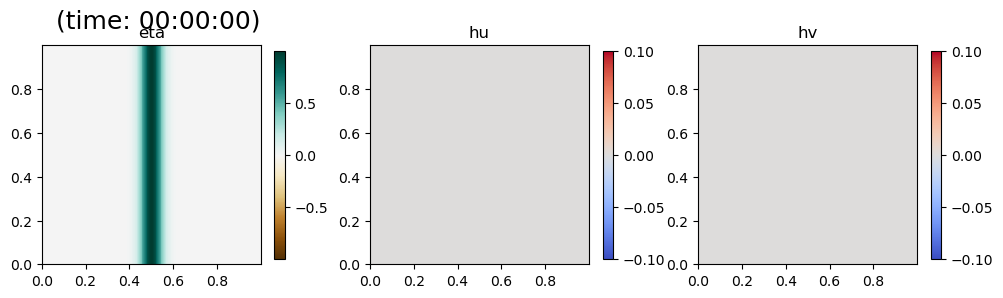

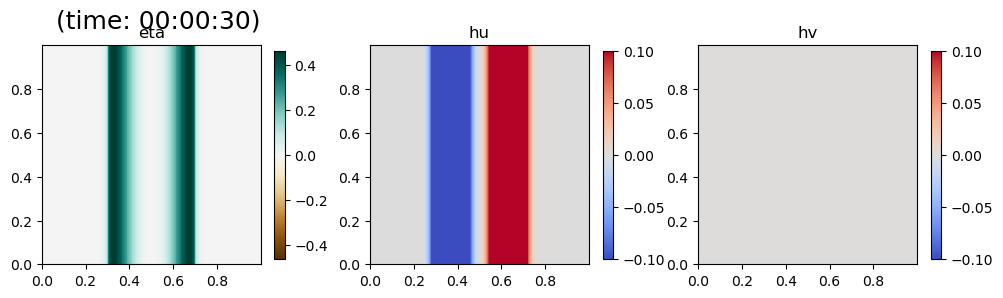

In [14]:
nx = 264
ny = nx
dt = 0.05
sim_bump = initKP07(nx, ny, dt,  init='bump', oneD=True)
PlotHelper.plotSim(sim_bump)

sim_bump.step(30)
PlotHelper.plotSim(sim_bump)

